In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import pycsou.operator.linop as pyop
from pycsou.util import view_as_real, view_as_complex

In [2]:
# Image parameters
image_height = 512
image_width = image_height
cmap = "gray"

In [3]:
# Gaussian filter params
gaussian_filter_sigma = 10

In [4]:
xx, yy = np.mgrid[:image_height, :image_width]
center_x = image_width/2
center_y = image_height/2
radius = 0.25 * (image_width + image_height)/2
disk = (xx - center_x) ** 2 + (yy - center_y) ** 2 < radius**2
disk = 1 * disk

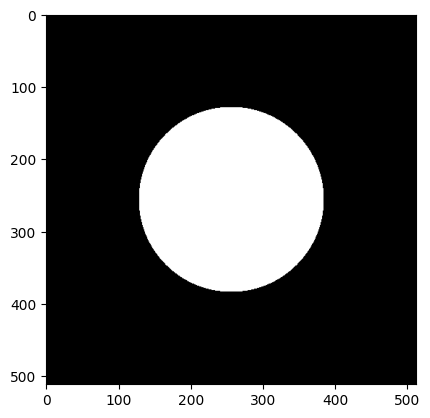

In [5]:
plt.imshow(disk, cmap=cmap)

In [6]:
gaussian_filtered_image = sp.ndimage.gaussian_filter(disk, sigma=gaussian_filter_sigma)

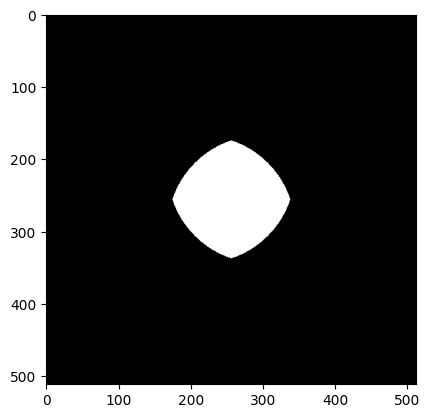

In [7]:
plt.imshow(gaussian_filtered_image, cmap=cmap)

In [8]:
def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    sos = sp.signal.butter(order, high, analog=False, btype='low', output='sos')
    return sos

def butter_lowpass_filter(data, highcut, fs, order=5):
    sos = butter_lowpass(highcut, fs, order=order)
    y = sp.signal.sosfiltfilt(sos, data)
    return y

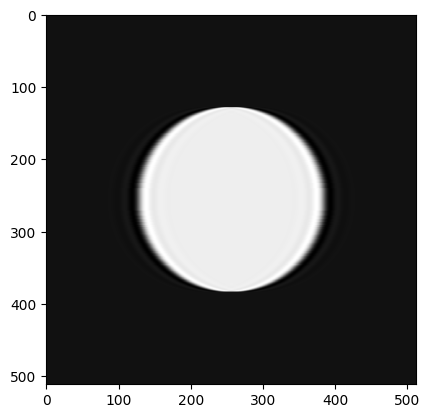

In [9]:
butter_filtered_image = butter_lowpass_filter(disk, 500, 10000)
plt.imshow(butter_filtered_image, cmap=cmap)

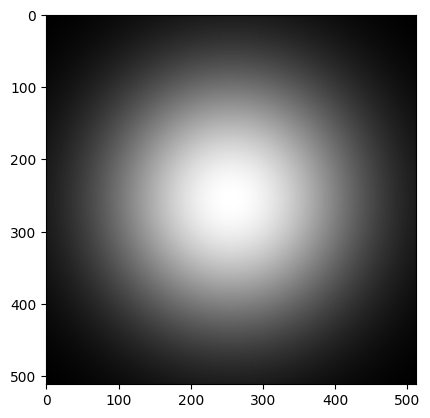

In [10]:
gaussian_image_sigma = 125
gaussian_image = np.exp(-((xx - center_x) ** 2 + (yy - center_y) ** 2)/(2 * gaussian_image_sigma ** 2))/np.sqrt((2 * np.pi * gaussian_image_sigma ** 2) ** 2)
plt.imshow(gaussian_image, cmap=cmap)

Defining the X-ray transform to be:
$$
P[f](n,t) = \int_{\mathbb{R}} f(t+an)da, \ n \in \mathbb{S}^{n-1}, \ t \in n^\perp
$$
we can compute that when $g(x) = \frac{1}{(2\pi\sigma^2)^{\frac{d}{2}}}\exp\left(-\frac{||x||_2^2}{2\sigma^2}\right)$, ie $g = f_Z$ where $Z \sim \mathcal{N}_d\left(0, \sigma^2 \text{I}_d\right)$,
$$
P[g](n,t) = g(t) = \frac{1}{(2\pi\sigma^2)^{\frac{d-1}{2}}}\exp\left(-\frac{||t||_2^2}{2\sigma^2}\right)
$$
which is radially symmetric.

Now define $g_q(x) = g(x-\Delta_q)$, we similarly obtain that:
$$
P[g_q](n,t) = \frac{1}{(2\pi \sigma^2)^{\frac{d-1}{2}}}\exp\left(-\frac{1}{2\sigma^2}\left(||t-\Delta_q||_2^2 + \langle n,\Delta_q \rangle^2\right)\right)
$$

Finally, define $$p(x) = \sum_{q=1}^Q a_q g(x-\Delta_q)$$

By linearity of $P$, we get:
$$
P[p](n,t) = \sum_{q=1}^Q a_q P[g_q](n,t) = \sum_{q=1}^Q a_q \frac{1}{(2\pi \sigma^2)^{\frac{d-1}{2}}}\exp\left(-\frac{1}{2\sigma^2}\left(||t-\Delta_q||_2^2 + \langle n,\Delta_q \rangle^2\right)\right)
$$


Also notice that:
- $g$ is essentially bandlimited.
- For $d=2$: $R[g](n,s) = P[g](n^\perp,sn) = g(sn) = \frac{1}{(2\pi\sigma^2)^{\frac{1}{2}}}\exp\left(-\frac{|s|^2}{2\sigma^2}\right)$ where $n \in \mathbb{S}^1$ and $s \in \mathbb{R}$. Similarly:
$$
R[p](n,s) = P[p](n^\perp,sn) = \sum_{q=1}^Q a_k \frac{1}{(2\pi \sigma^2)^{\frac{1}{2}}}\exp\left(-\frac{1}{2\sigma^2}\left(||sn-\Delta_q||_2^2 + \langle n^\perp,\Delta_q \rangle^2\right)\right)
$$
Defining $a \times b = a_1b_2 - a_2b_1$:
$$
R[p](n,s) = \sum_{q=1}^Q a_q \frac{1}{(2\pi \sigma^2)^{\frac{1}{2}}}\exp\left(-\frac{1}{2\sigma^2}\left(||sn-\Delta_q||_2^2 + \left(n \times \Delta_q\right)^2\right)\right)
$$

Since $R[g]$ does not depend on $n$, we plot it for values of $s$:

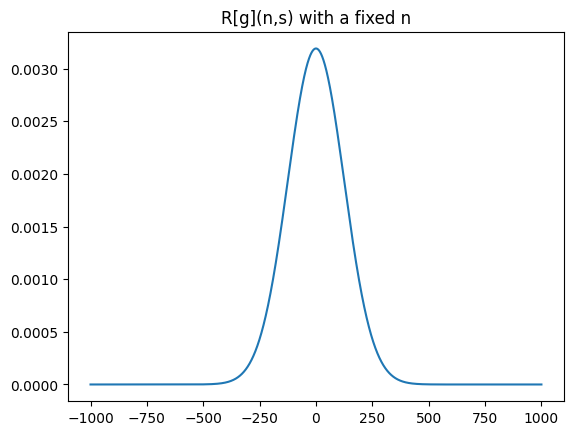

In [11]:
lower_lim_s = -1000
upper_lim_s = 1000
num_plot_samples = 20000
lin = np.linspace(lower_lim_s, upper_lim_s, num=num_plot_samples)
plt.plot(lin, np.exp(-(lin ** 2)/(2 * gaussian_image_sigma ** 2))/np.sqrt(2 * np.pi * gaussian_image_sigma ** 2))
plt.title(label="R[g](n,s) with a fixed n");


With the following convention for the Fourier transform:
$$
\mathcal{F}_d(f)(v) = \int_{\mathbb{R}^d} f(x) \exp(-j2\pi \langle v, x \rangle)dx
$$
we have that:
$$
\mathcal{F}_d(g)(v) = \exp\left(-2(\pi \sigma)^2 ||v||_2^2\right)
$$
Thus, by the Fourier Slice theorem, for $d=2$:
$$
\mathcal{F}_1(R[g](n, .))(\alpha) = \mathcal{F}_2(g)(\alpha n) = \exp\left(-2(\pi \sigma)^2 ||\alpha n||_2^2\right) = \exp\left(-2(\pi \sigma)^2 |\alpha|^2\right), \ n \in \mathbb{S}^1,\ \alpha \in \mathbb{R}
$$

Now, we compute the Fourier transform of the function $p(x) = \sum_{q=1}^Q a_q g(x-\Delta_q)$:
$$
\mathcal{F}_d(p)(v) = \exp\left(-2(\pi \sigma)^2 ||v||_2^2\right) \sum_{q=1}^Q a_q e^{-j2\pi \langle \Delta_q, v \rangle} = \mathcal{F}_d(g)(v)\sum_{q=1}^Q a_q e^{-j2\pi \langle \Delta_q, v \rangle}
$$
Thus, with $d=2$, recalling that $||n||_2 = 1$:
$$
\mathcal{F}_1(R[p](n,.))(\alpha) = \mathcal{F}_2(p)(\alpha n) = \exp\left(-2(\pi \sigma)^2 |\alpha|^2\right) \sum_{q=1}^Q a_q e^{-j2\pi  \langle \Delta_q, \alpha n \rangle} = \mathcal{F}_2(g)(\alpha n)\sum_{q=1}^Q a_q e^{-j2\pi  \langle \Delta_q, \alpha n \rangle}
$$

Sampling at frequencies $v_1, \ldots, v_L \in \mathbb{R}^d$ and $\omega_1, \ldots, \omega_K \in \mathbb{R}$:
$$
\begin{align*}
\mathcal{F}_d(p)(v_k) &= \exp\left(-2(\pi \sigma)^2 ||v_k||_2^2\right) \sum_{q=1}^Q a_q e^{-j2\pi \langle \Delta_q, v_k \rangle}, \ k = 1 \ldots L\\
&= \mathcal{F}_d(g)(v_k)\text{NUFFT}_{\text{III:} 2\pi\Delta, v}(a)[k]
\end{align*}
$$
and
$$
\begin{align*}
\mathcal{F}_1(R[p](n,.))(\omega_i) &= \exp\left(-2(\pi \sigma)^2 |\omega_i|^2\right) \sum_{q=1}^Q a_q e^{-j2\pi  \langle \Delta_q, \omega_i n\rangle}, \ i=1 \ldots K\\
&= \Phi(\omega_i)\text{NUFFT}_{\text{III:} 2\pi\Delta, n\omega^T}(a)[i]
\end{align*}
$$
where:
$$
\begin{align*}
\Delta &= \begin{bmatrix} \Delta_1 & \ldots & \Delta_Q \end{bmatrix} \in \mathbb{R}^{2 \times Q}\\
a &= \begin{bmatrix} a_1 & \ldots & a_Q \end{bmatrix}^T \in \mathbb{R}^{Q}\\
v &= \begin{bmatrix} v_1 & \ldots & v_L \end{bmatrix} \in \mathbb{R}^{d \times L}\\
\omega &= \begin{bmatrix} \omega_1 & \ldots & \omega_K \end{bmatrix}^T \in \mathbb{R}^{K}\\
\Phi(\omega) &= \mathcal{F}_1(f_Z)(\omega) \ \text{where }Z \sim \mathcal{N}_1(0, \sigma^2)
\end{align*}
$$
and, letting $x = \begin{bmatrix} x_1 & \ldots & x_M \end{bmatrix} \in \mathbb{R}^{d \times M}$, $y = \begin{bmatrix} y_1 & \ldots & y_M \end{bmatrix} \in \mathbb{R}^{d \times N}$ and $b \in \mathbb{R}^M$:
$$
\text{NUFFT}_{\text{III:}x,y}(b)[n] = \sum_{i=1}^M b_i e^{-i\langle x_i, y_n \rangle}, \ n = 1 \ldots N
$$

Wow that's a lot of LaTeX for a notebook. Time to code.
Implementing for $d=2$:
$$
p(x) = \sum_{q=1}^Q a_q g(x-\Delta_q) = \sum_{q=1}^Q a_q \frac{1}{2\pi \sigma^2}\exp\left(-\frac{1}{2\sigma^2}||x-\Delta_q||_2^2\right)
$$

In [12]:
def gaussian_density(x, y, sigma, dim=2):
    return np.exp(-(x ** 2 + y ** 2)/(2 * (sigma ** 2)))/((2 * np.pi *sigma ** 2 ) ** (dim/2.))

def p_function(x, y, a, delta_x, delta_y, sigma):
    temp = np.array([gaussian_density(x-dx, y-dy, sigma) for dx, dy in zip(delta_x, delta_y)])
    return (temp.T @ a).T

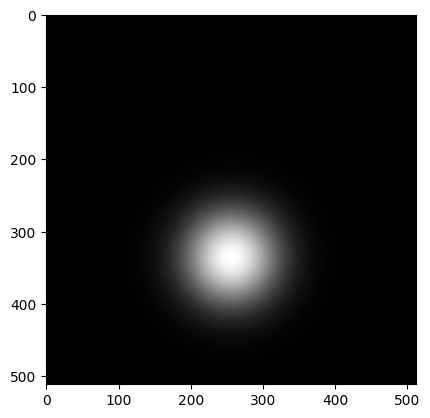

In [53]:
# delta_x = np.array([image_height/4, -image_height/4, image_height/28 - 20, -image_height/6])/1.3
# delta_y = np.array([image_width/4, image_width/4, -image_width/5, -image_width/4])/1.3
delta_x = np.array([80])
delta_y = np.array([0])

sigma_p = 45
p_vals = p_function(xx-center_x, yy-center_y, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.imshow(p_vals, cmap=cmap);

And its Fourier transform:
$$
\begin{align*}
\mathcal{F}_2(p)(v_k) &= \exp\left(-2(\pi \sigma)^2 ||v_k||_2^2\right) \sum_{q=1}^Q a_q e^{-j2\pi \langle \Delta_q, v_k \rangle}, \ k = 1 \ldots L\\
&= \mathcal{F}_2(g)(v_k)\text{NUFFT}_{\text{III:} 2\pi\Delta, v}(a)[k]
\end{align*}
$$


In [54]:
def fourier_g(v, sigma):
    return np.exp((-2 * (np.pi * sigma) ** 2) * np.sum(v ** 2,axis=-1))

def fourier_p(v, a, delta_x, delta_y, sigma):
    temp = pyop.nufft.NUFFT.type3(2 * np.pi * np.array(list(zip(delta_x, delta_y))), v, isign=-1, real=True, eps=0).apply(a)
    return view_as_complex(temp) * fourier_g(v, sigma)

Now, its analytical Radon transform:
$$
R[p](n,s) = \sum_{q=1}^Q a_q \frac{1}{(2\pi \sigma^2)^{\frac{1}{2}}}\exp\left(-\frac{1}{2\sigma^2}\left(||sn-\Delta_q||_2^2 + \left(n \times \Delta_q\right)^2\right)\right)
$$

In [55]:
def radon_p_analytical(n, s, a, delta_x, delta_y, sigma):

    def radon_p_helper(delta):
        t = np.array([si * n for si in s]) - delta
        curl = np.array(
            [
                [0, -1],
                [1, 0]
            ],
        )
        curl_prod = np.inner((curl @ n.T).T, delta)
        tmp = (t ** 2).sum(axis=-1)
        ret = np.exp(-(tmp + curl_prod ** 2)/(2 * (sigma ** 2)))
        return ret/np.sqrt(2 * np.pi * sigma ** 2)

    temp = np.array([radon_p_helper(delta) for delta in zip(delta_x, delta_y)])
    return (temp.T @ a).T

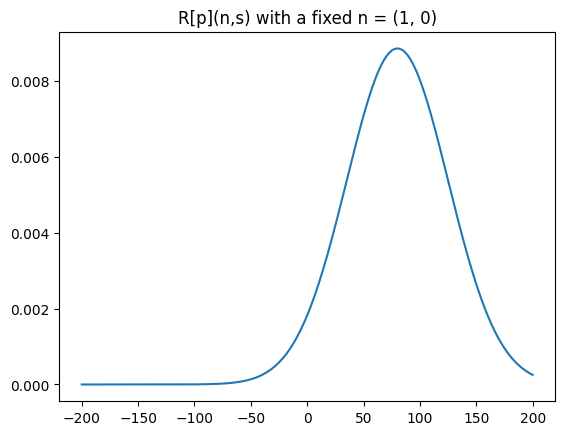

In [56]:
n = np.array([1, 0])
s = np.linspace(-200, 200, num=1000)
radon_p_vals = radon_p_analytical(n, s, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.plot(s, radon_p_vals)
plt.title(label="R[p](n,s) with a fixed n = (1, 0)");

Now that we can compute the Radon transform of $p$ analytically directly, let's compute it via inversion of $\mathcal{F}_2(p)$, as suggested by the Fourier slice theorem:

Let $f: \mathbb{R}^d \to \mathbb{R}$ with finite time-support in $B_d(0,T)$ and essentially finite frequency-support $B_d(0, V)$, then setting $N = \left\lceil \frac{TV}{2}\right\rceil$:
$$
R[f](n,s) = \sum_{m=-N}^N \frac{1}{T} \mathcal{F}_2(f)\left(\frac{mn}{T}\right)e^{j\frac{2\pi}{T}ms}
$$

When sampled at $s_1, \ldots, s_P$:
$$
R[f](n,s_p) = \text{NUFFT}_{\text{II:}-\frac{2\pi}{T}s}(u_{f,n})[p], \ p = 1 \ldots P
$$
where $u_{f,n}^m = \frac{1}{T}\mathcal{F}_2(f)\left(\frac{mn}{T}\right)$.

Note that $p$ is not time-limited but it can be approximated as such, as it is essentially a GMM. Also note that we will still use an NUFFT of type III in practice as the sample points do not lie in $[-\pi,\pi)$.

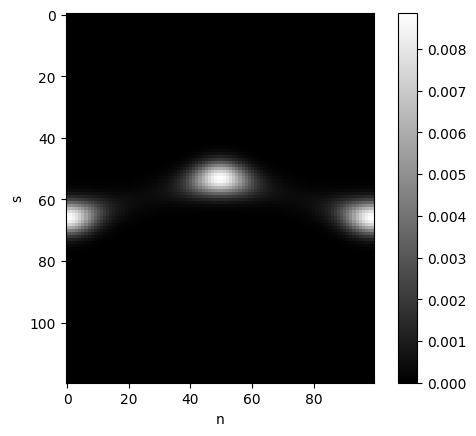

In [57]:
thetas = np.linspace(0, 2 * np.pi, num=100)
s = np.linspace(-750, 750, num=120)
radon_p_vals = radon_p_analytical(np.array(list(zip(np.cos(thetas), np.sin(thetas)))), s, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.imshow(radon_p_vals, cmap=cmap)
plt.colorbar()
plt.ylabel("s")
plt.xlabel("n");

In [58]:
def radon_p_inv_fourier(n, s, a, delta_x, delta_y, sigma, time_support=4000, freq_support=4000):
    time_bandwidth_product = np.ceil(time_support * freq_support / 2.)
    m = np.arange(-time_bandwidth_product, time_bandwidth_product+1)
    return pyop.NUFFT.type3(m, (2 * np.pi/time_support) * s, isign=1, real=False, eps=0)(
        view_as_real(fourier_p(np.array(np.outer(n, m).T)/time_support, a, delta_x, delta_y, sigma)/time_support)
    )

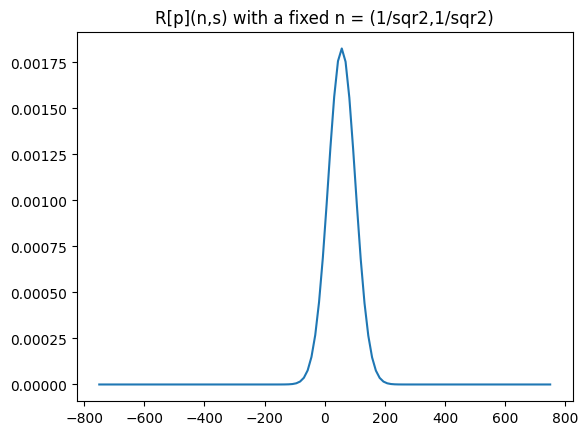

In [59]:
n = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
radon_p_vals = radon_p_analytical(n, s, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.plot(s, radon_p_vals)
plt.title(label="R[p](n,s) with a fixed n = (1/sqr2,1/sqr2)");

In [60]:
thetas = np.linspace(0, np.pi, num=20)
s = np.linspace(-750, 750, num=120)

In [61]:
%%time
results = np.array([view_as_complex(radon_p_inv_fourier(np.array([np.cos(thetas[i]), np.sin(thetas[i])]), s, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)) for i in range(len(thetas))])

CPU times: user 23min 51s, sys: 11.6 s, total: 24min 2s
Wall time: 1min 52s


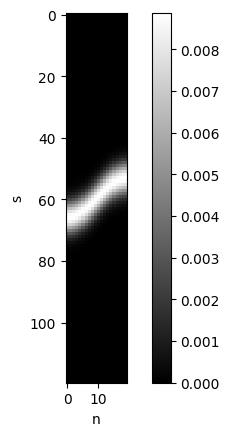

In [62]:
plt.imshow(np.real(results).T, cmap=cmap)
plt.colorbar()
plt.xlabel("n")
plt.ylabel("s");

In [63]:
n = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
s1 = np.linspace(-100, 100, num=1000)
radon_p_vals = radon_p_inv_fourier(n, s1, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)

In [64]:
np.real(view_as_complex(radon_p_vals))

array([2.08455814e-05, 2.11705517e-05, 2.15001626e-05, 2.18344731e-05,
       2.21735429e-05, 2.25174326e-05, 2.28662030e-05, 2.32199159e-05,
       2.35786337e-05, 2.39424193e-05, 2.43113364e-05, 2.46854494e-05,
       2.50648232e-05, 2.54495237e-05, 2.58396173e-05, 2.62351709e-05,
       2.66362525e-05, 2.70429306e-05, 2.74552743e-05, 2.78733537e-05,
       2.82972393e-05, 2.87270026e-05, 2.91627158e-05, 2.96044515e-05,
       3.00522836e-05, 3.05062863e-05, 3.09665347e-05, 3.14331048e-05,
       3.19060731e-05, 3.23855171e-05, 3.28715149e-05, 3.33641456e-05,
       3.38634888e-05, 3.43696252e-05, 3.48826360e-05, 3.54026035e-05,
       3.59296106e-05, 3.64637410e-05, 3.70050794e-05, 3.75537111e-05,
       3.81097225e-05, 3.86732007e-05, 3.92442334e-05, 3.98229096e-05,
       4.04093189e-05, 4.10035517e-05, 4.16056994e-05, 4.22158542e-05,
       4.28341093e-05, 4.34605585e-05, 4.40952968e-05, 4.47384199e-05,
       4.53900245e-05, 4.60502081e-05, 4.67190691e-05, 4.73967069e-05,
      

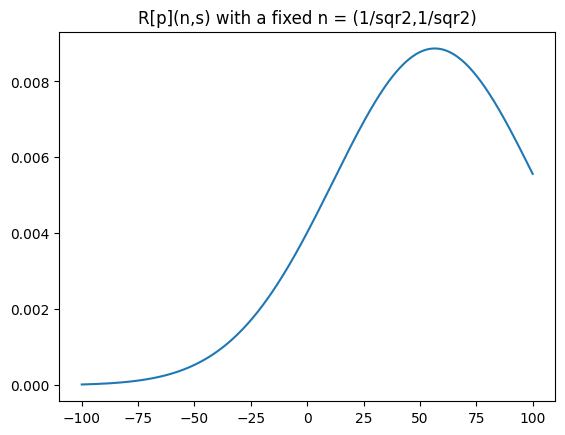

In [65]:
plt.plot(s1, np.real(view_as_complex(radon_p_vals)))
plt.title(label="R[p](n,s) with a fixed n = (1/sqr2,1/sqr2)");

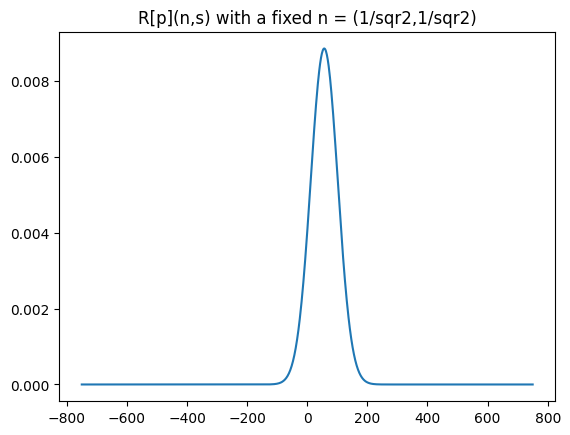

In [66]:
s2 = np.linspace(-750, 750, num=1000)
radon_p_vals = radon_p_inv_fourier(n, s2, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.plot(s2, np.real(view_as_complex(radon_p_vals)))
plt.title(label="R[p](n,s) with a fixed n = (1/sqr2,1/sqr2)");

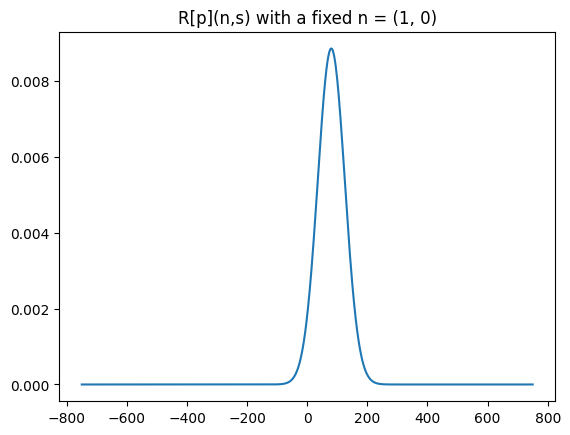

In [67]:
n = np.array([1, 0])
radon_p_vals = radon_p_inv_fourier(n, s2, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.plot(s2, np.real(view_as_complex(radon_p_vals)))
plt.title(label="R[p](n,s) with a fixed n = (1, 0)");

In [68]:
# just testing a non NUFFT based inversion

def radon_p_inv_fourier_2(n, s, a, delta_x, delta_y, sigma, time_support=500, freq_support=500):
    time_bandwidth_product = np.ceil(time_support * freq_support / 2.)
    m = np.arange(-time_bandwidth_product, time_bandwidth_product+1)
    return (fourier_p(np.array(np.outer(n, m).T)/time_support, a, delta_x, delta_y, sigma)/time_support) @ np.exp(1j * (2 * np.pi / time_support) * np.outer(m, s))


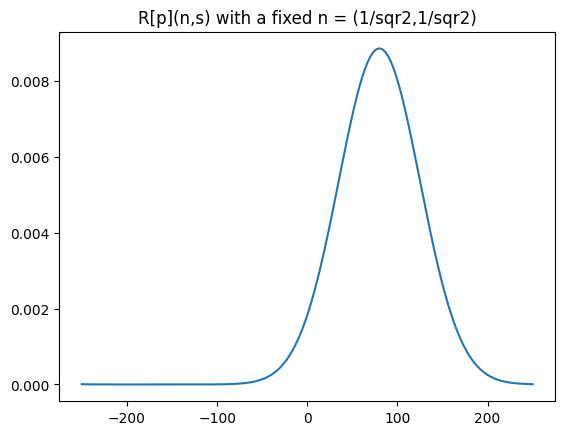

In [69]:
s2 = np.linspace(-250, 250, num=1000)
radon_p_vals = radon_p_inv_fourier_2(n, s2, np.ones(len(delta_x)), delta_x, delta_y, sigma_p)
plt.plot(s2, np.real(radon_p_vals))
plt.title(label="R[p](n,s) with a fixed n = (1/sqr2,1/sqr2)");